In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import tokenizers
import tensorflow as tf
import tensorflow.keras.backend as K
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from transformers import *
from keras.models import Model, load_model
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Flatten, Conv1D, Dropout, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping



In [32]:
pip install cufflinks

  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=efad2238d598dfe209ae2fbe2ed5eba396babfb94186a59d99399910627b4552
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\e1\27\13\3fe67fa7ea7be444b831d117220b3b586b872c9acd4df480d0
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=d0ec7dd11e960096ad438bb26e7d3916e5e4f0afe8d71a63e87649e297a83561
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built cufflinks retrying
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
print(train_data.isnull().sum())
print("----------------------")
print(test_data.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
----------------------
textID       0
text         0
sentiment    0
dtype: int64


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [6]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
train_data.dropna(inplace=True)

In [9]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,32f4183741,go with firefox,good,neutral
freq,1,1,199,11117


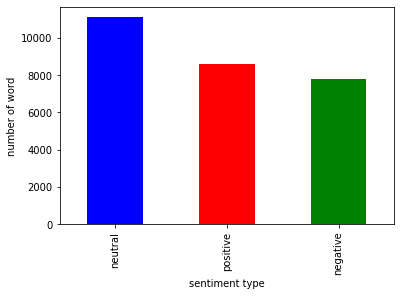

In [10]:
count = pd.value_counts(train_data['sentiment'],sort = True)
count.plot(kind = 'bar',color = ({'red','green','blue'}))

plt.xlabel('sentiment type')
plt.ylabel('number of word')
plt.show()

In [11]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [22]:
def no_punc(text):
    return  "".join([x for x in text if x not in string.punctuation])

def no_stopwords(text):
    return [x for x in text if (x not in stopwords.words('english') or x not in'im')]

lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    return [lemmatizer.lemmatize(x) for x in text]
stemmer = PorterStemmer()
def word_stemmer(text):
    return " ".join([stemmer.stem(x) for x in text])


train_data['text_nopunc']=train_data['selected_text'].apply(str).apply(lambda x: no_punc(x.lower()))


tokenizer = RegexpTokenizer('\w+')  
train_data['text_tokens'] = train_data['text_nopunc'].apply(str).apply(lambda x: tokenizer.tokenize(x))

train_data['text_nostopwords'] = train_data['text_tokens'].apply(lambda x : no_stopwords(x))

train_data['text_lem'] = train_data['text_nostopwords'].apply(lambda x : word_lemmatizer(x))

train_data['text_stem'] = train_data['text_lem'].apply(lambda x : word_stemmer(x))
train_data.head()

,textID,text,selected_text,sentiment,text_nopunc,text_tokens,text_nostopwords,text_lem,text_stem
0,cb774db0d1,"I`d have responded, if I were going","i`d have responded, if i were going",neutral,id have responded if i were going,"[id, have, responded, if, i, were, going]","[id, have, responded, if, were, going]","[id, have, responded, if, were, going]",id have respond if were go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,sooo sad,negative,sooo sad,"[sooo, sad]","[sooo, sad]","[sooo, sad]",sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying me,"[bullying, me]","[bullying, me]","[bullying, me]",bulli me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave me alone,"[leave, me, alone]","[leave, me, alone]","[leave, me, alone]",leav me alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","sons of ****,",negative,sons of,"[sons, of]","[sons, of]","[son, of]",son of


In [29]:
neu_train = train_data[train_data['sentiment'] == 'neutral']
pos_train = train_data[train_data['sentiment'] == 'positive']
neg_train = train_data[train_data['sentiment'] == 'negative']

fdist_neu = FreqDist(neu_train['text_stem'])
top_neu = fdist_neu.most_common(40)

df1 = pd.DataFrame(top_neu, columns = ['Text', 'Count'])


fdist_pos = FreqDist(pos_train['text_stem'])
top_pos = fdist_pos.most_common(40)

fdist_neg = FreqDist(neg_train['text_stem'])
top_neg = fdist_neg.most_common(40)



AttributeError: 'Series' object has no attribute 'iplot'

In [35]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

fdist_neu = FreqDist(neu_train['text_stem'])
top_neu = fdist_neu.most_common(40)


df1 = pd.DataFrame(top_neu, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', color='red')

In [38]:
fdist_pos = FreqDist(pos_train['text_stem'])
top_pos = fdist_pos.most_common(40)


df1 = pd.DataFrame(top_pos, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', color='green')

In [39]:
fdist_neg = FreqDist(neg_train['text_stem'])
top_neg = fdist_neg.most_common(40)


df1 = pd.DataFrame(top_neg, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', color='blue')

In [26]:
print(top_neg)

[('miss', 250), ('sorri', 158), ('sad', 156), ('hate', 109), ('suck', 95), ('', 95), ('bore', 86), ('bad', 85), ('hurt', 83), ('tire', 73), ('sick', 68), ('fail', 41), ('headach', 35), ('unfortun', 34), ('stupid', 34), ('ugh', 32), ('lost', 31), ('sadli', 29), ('hard', 27), ('cri', 27), ('poor', 25), ('die', 24), ('problem', 22), ('kill', 19), ('jealou', 18), ('horribl', 18), ('pain', 18), ('depress', 18), ('wtf', 18), ('stuck', 17), ('upset', 16), ('shame', 15), ('forgot', 15), ('annoy', 15), ('so sad', 14), ('broke', 14), ('im sorri', 13), ('lame', 13), ('wrong', 13), ('dead', 13)]


In [17]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [170]:
import tokenizers
max_length = 200

tokenizer = tokenizers.ByteLevelBPETokenizer(
                vocab_file= 'vocab.json',
                merges_file = 'merges.txt',
                lowercase =True,
                add_prefix_space = True
)

sentiment_id = {'neutral':tokenizer.encode('neutral').ids[0],
                'negative' : tokenizer.encode('negative').ids[0],
                'positive' : tokenizer.encode('positive').ids[0]}

train_data= pd.read_csv('train.csv').fillna('')
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [171]:

temp = train_data.shape[0]
input_ids = np.ones((temp,max_length),dtype='int32')
attention_mask = np.zeros((temp, max_length),dtype='int32')
token_type = np.zeros((temp,max_length),dtype='int32')
start_mask = np.zeros((temp,max_length),dtype='int32')
end_mask = np.zeros((temp,max_length),dtype='int32')

for i in range(temp):
    text1 = " "+" ".join(train_data.loc[i,'text'].split())
    text2 = " ".join(train_data.loc[i, 'selected_text'].split())
    index = text1.find(text2)
    text2_loc = np.zeros((len(text1)))
    text2_loc[index:index+len(text2)]=1
    
    if text1[index-1]==" ": text2_loc[index-1]=1
    encode_text1 = tokenizer.encode(text1)
    
    s_text_token_index = []
    

    index = 0
    offsets = []
    for j in encode_text1.ids:
        w = tokenizer.decode([j])
        offsets.append((index,index+len(w)))
        
        index+=len(w)
        
    
    for k,(x,y) in enumerate(encode_text1.offsets):
        sum_val = np.sum(text2_loc[x:y])
        if sum_val > 0:
            s_text_token_index.append(k)
        
        
    senti_token = sentiment_id[train_data.loc[i,'sentiment']]
    input_ids[i,:len(encode_text1.ids)+5] = [0] +encode_text1.ids+[2,2]+[senti_token]+[2]
    attention_mask[i,:len(encode_text1.ids)+5]=1
    
    if len(s_text_token_index) > 0:
        start_mask[i,s_text_token_index[0]+1] = 1
        end_mask[i, s_text_token_index[-1]+1] = 1
        
        
    

In [172]:
def loss_function(answer,prediction):
    loss = tf.keras.losses.categorical_crossentropy(answer,prediction, from_logits = False , label_smoothing = 0.2)
    loss = tf.reduce_mean(loss)
    return loss



In [181]:
def build_model():
    ids = tf.keras.layers.Input((max_length,), dtype=tf.int32)
    att = tf.keras.layers.Input((max_length,), dtype=tf.int32)
    tok = tf.keras.layers.Input((max_length,), dtype=tf.int32)
    PATH = '../NLP'
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.kears.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)
    
    
    model = tf.keras.models.Model(inputs=[ids,att,tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizer.Adam(learning_rate = 3e-10)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer)
    
    return model

In [187]:
temp2 = test_data.shape[0]

input_ids_test = np.ones((temp2,max_length),dtype='int32')
attention_mask_test = np.zeros((temp2, max_length),dtype='int32')
token_type_test = np.zeros((temp2,max_length),dtype='int32')

for i range in(temp2):
    text1 = " "+" ".join(test_data.loc[i,'text'].split())
    encode_text1 = tokenizer.encode(text1)
    
    senti_token = sentiment_id[test_data.loc[i,'sentiment']]
    input_ids_test[i,:len(enc_text1.ids)+5] = [0] + enc.ids + [2,2] + [senti_token] + [2]
    attention_mask_test[i,:len(enc_text1.ids)+5] = 1

    
preds_start= np.zeros((input_ids_test.shape[0],max_len))
preds_end= np.zeros((input_ids_test.shape[0],max_len))

model = build_model()


SyntaxError: invalid syntax (<ipython-input-187-11b0bc78ec47>, line 7)